# Accessing Sentinel-5P data with the Planetary Computer STAC API 

Example notebook taken from the Microsoft Planetary Computer [datasets page on Sentinel-5P data](https://planetarycomputer.microsoft.com/dataset/sentinel-5p-l2-netcdf#Example-Notebook). 

The Copernicus [Sentinel-5 Precursor](https://sentiwiki.copernicus.eu/web/s5p-mission) mission provides high spatio-temporal resolution measurements of the Earth's atmosphere. Sentinel-5P Level-2 data products include total columns of ozone, sulfur dioxide, nitrogen dioxide, carbon monoxide and formaldehyde, tropospheric columns of ozone, vertical profiles of ozone and cloud & aerosol information. The Planetary Computer's [sentinel-5p-l2-netcdf](https://planetarycomputer.microsoft.com/dataset/sentinel-5p-l2-netcdf) STAC Collection contains Items for thirteen Sentinel-5P Level-2 products in NetCDF format:

- L2__AER_AI: Ultraviolet aerosol index
- [`L2__AER_LH`](https://www.tropomi.eu/data-products/aerosol-layer-height): Aerosol layer height
- [`L2__CH4___`](https://www.tropomi.eu/data-products/methane): Methane (CH4) total column
- [`L2__CLOUD_`](https://www.tropomi.eu/data-products/cloud): Cloud fraction, albedo, and top pressure
- [`L2__CO____`](https://www.tropomi.eu/data-products/carbon-monoxide): Carbon monoxide (CO) total column
- [`L2__HCHO__`](https://www.tropomi.eu/data-products/formaldehyde): Formaldehyde (HCHO) total column
- [`L2__NO2___`](https://www.tropomi.eu/data-products/nitrogen-dioxide): Nitrogen dioxide (NO2) total column
- L2__O3____: Ozone (O3) total column
- L2__O3_TCL: Ozone (O3) tropospheric column
- L2__SO2___: Sulfur dioxide (SO2) total column
- L2__NP_BD3: Cloud from the Suomi NPP mission, band 3
- L2__NP_BD6: Cloud from the Suomi NPP mission, band 6
- L2__NP_BD7: Cloud from the Suomi NPP mission, band 7



### Environment setup

Follow the [Required Dependencies](https://scitools.org.uk/cartopy/docs/latest/installing.html) section to install Cartopy and install its basic functionalities. These packages can be installed using pip.

We include a conda environment file that contains a list of all the dependencies required to build and install cartopy, which can be used to install pre-built binaries of all the dependencies on your local system. To use it:

```
git clone https://github.com/SciTools/cartopy.git
cd cartopy
conda env create -f environment.yml
conda activate cartopy-dev
pip install -e .
```

Following the [Xarray documention](https://docs.xarray.dev/en/latest/getting-started-guide/installing.html) to install xarray with its recommended dependencies using the conda command line tool:
```
conda install -c conda-forge xarray dask netCDF4 bottleneck
```
Install `netcdf4` and `h5netCDF`
```
conda install netcdf4 h5netcdf
```

Install the [AIOHTTP package](https://docs.aiohttp.org/en/stable/) for Async HTTP client/server for asyncio and Python.
```
pip install aiohttp
```

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the Planetary Computer Hub to run this notebook, then your API key is automatically set to the environment variable PC_SDK_SUBSCRIPTION_KEY for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable PC_SDK_SUBSCRIPTION_KEY or the following code:

````
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)

In [1]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr

In [2]:
#show version of installed packages
print(xr.show_versions())


INSTALLED VERSIONS
------------------
commit: None
python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
python-bits: 64
OS: Darwin
OS-release: 23.5.0
machine: arm64
processor: arm
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: ('en_US', 'UTF-8')
libhdf5: 1.14.3
libnetcdf: 4.9.2

xarray: 2024.5.0
pandas: 2.2.2
numpy: 1.26.4
scipy: 1.13.1
netCDF4: 1.6.5
pydap: None
h5netcdf: 1.3.0
h5py: 3.11.0
zarr: 2.18.2
cftime: 1.6.3
nc_time_axis: 1.4.1
iris: None
bottleneck: 1.3.8
dask: 2024.5.1
distributed: 2024.5.1
matplotlib: 3.8.4
cartopy: 0.23.1.dev16+gea946a1d
seaborn: 0.13.2
numbagg: 0.8.1
fsspec: 2024.5.0
cupy: None
pint: None
sparse: None
flox: 0.9.7
numpy_groupies: 0.11.1
setuptools: 70.0.0
pip: 24.0
conda: None
pytest: 8.2.1
mypy: 1.10.0
IPython: 8.24.0
sphinx: 7.3.7
None


### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://learn.microsoft.com/en-us/azure/storage/blobs/). We'll use pystac-client to search the Planetary Computer's STAC API for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a modifier so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See Reading from the STAC API and Using tokens for data access for more.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Select an area, time, and product type and find STAC Items

Let's search for Items containing the formaldehyde product (`L2__HCHO__`) over the country of India. We'll further limit our search to an arbitrary collection date of April 2, 2024 and only include data that has been processed "offline" (`OFFL`). The geospatial extents of `OFFL` Items are much larger than those processed in near real-time (`NRTI`).

In [4]:
# India
# longitude = 79.109
# latitude = 22.746

# Laos
longitude = 102.4955
latitude = 19.8563

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2024-04-02/2024-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "hcho"}},
)
items = list(search.items())

print(f"Found {len(items)} items:")


Found 2 items:


Let's take a look at the first Item in the list.

In [5]:
f = fsspec.open(items[0].assets["hcho"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")

ds

<xarray.Dataset> Size: 53MB
Dimensions:                                              (scanline: 4173,
                                                          ground_pixel: 450,
                                                          time: 1, corner: 4,
                                                          layer: 34)
Coordinates:
  * scanline                                             (scanline) float64 33kB ...
  * ground_pixel                                         (ground_pixel) float64 4kB ...
  * time                                                 (time) datetime64[ns] 8B ...
  * corner                                               (corner) float64 32B ...
  * layer                                                (layer) int32 136B 0...
Data variables:
    latitude                                             (time, scanline, ground_pixel) float32 8MB ...
    longitude                                            (time, scanline, ground_pixel) float32 8MB ...
    delta_time                                           (time, scanline, ground_pixel) datetime64[ns] 15MB ...
    time_utc                                             (time, scanline) object 33kB ...
    qa_value                                             (time, scanline, ground_pixel) float32 8MB ...
    formaldehyde_tropospheric_vertical_column            (time, scanline, ground_pixel) float32 8MB ...
    formaldehyde_tropospheric_vertical_column_precision  (time, scanline, ground_pixel) float32 8MB ...

Plotting the data in its native coordinate system is not very informative.

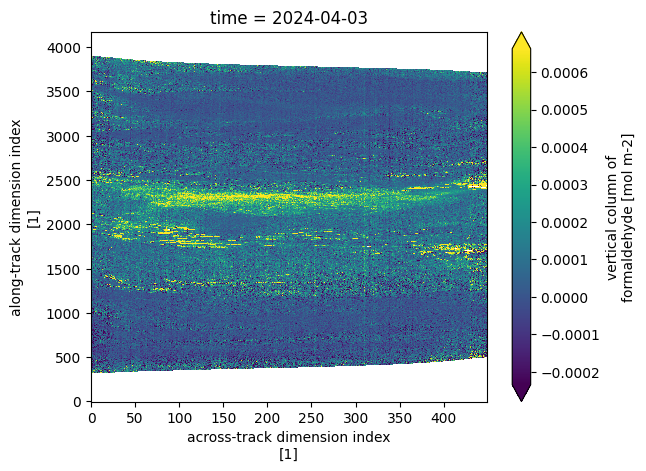

In [6]:
varname = "formaldehyde_tropospheric_vertical_column"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="viridis");

We'll plot the data in its native geographic coordinate reference system along with continent boundaries for context.

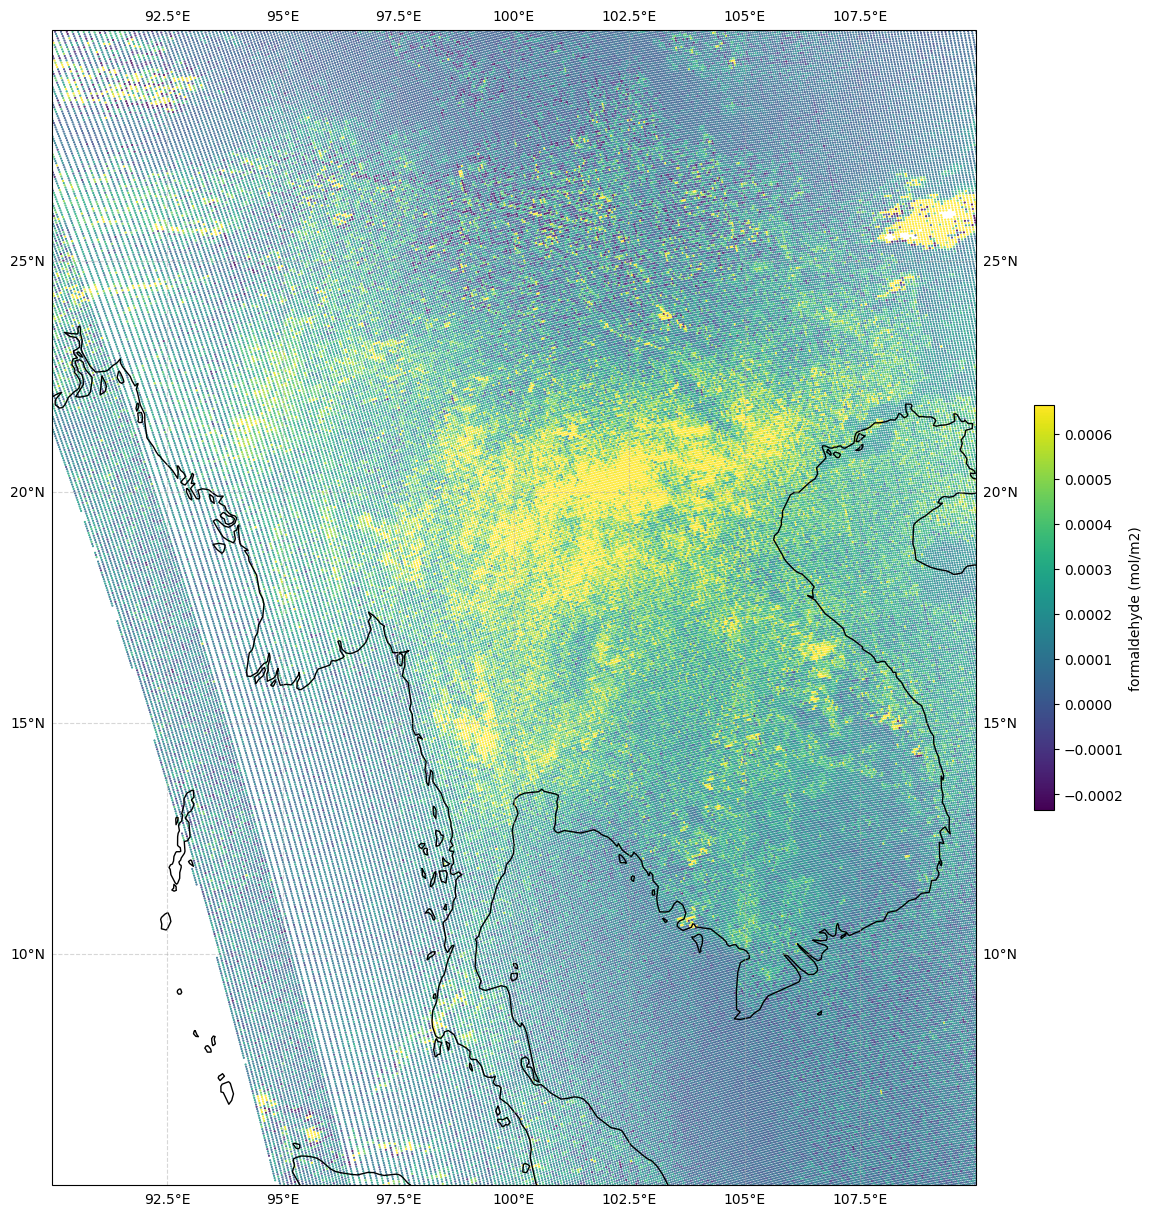

In [16]:
# formaldehyde product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
# ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_extent([90, 110, 5, 30], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=formaldehyde,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    norm=norm,
    marker=".",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
plt.show()